In [485]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import math
import statistics
import scipy.stats
from scipy.stats import pearsonr
import time
from datetime import datetime
import matplotlib.dates as mdates
import warnings

# Sklearn
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import plot_importance
from lightgbm import plot_importance as l_pi

# Models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

%matplotlib inline
warnings.filterwarnings("ignore")

In [18]:
df1 = pd.read_csv("data1.csv")
df2 = pd.read_csv("data2_1.csv")
df3 = pd.read_csv("data3_1.csv")

In [53]:
df_1 = pd.concat([df1, df2, df3])

In [55]:
df_1.head()

,date,price,item_id,warehouse_id,quantity,amount,sebes
0,2021-01-04 00:00:00,0.00,7d185936-7a60-11eb-ba7f-4a6a34607ded,01ffab2c-3c70-11ec-ba95-4a6a34607ded,1,59.99,53.5
1,2021-01-04 00:00:00,0.00,7d185936-7a60-11eb-ba7f-4a6a34607ded,01ffab2c-3c70-11ec-ba95-4a6a34607ded,1,59.99,53.5
2,2021-01-04 00:00:00,0.00,7d185936-7a60-11eb-ba7f-4a6a34607ded,01ffab2c-3c70-11ec-ba95-4a6a34607ded,1,59.99,53.5
3,2021-01-04 00:00:00,0.00,7d185936-7a60-11eb-ba7f-4a6a34607ded,bb818041-3c6f-11ec-ba95-4a6a34607ded,1,59.99,53.5
4,2021-01-04 00:00:00,59.99,7d185936-7a60-11eb-ba7f-4a6a34607ded,d91c6b6b-50f4-11ec-ba96-4a6a34607ded,1,59.99,53.5


In [58]:
df_1.quantity.max()

20

In [555]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7881 entries, 0 to 7
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          7881 non-null   object 
 1   price         7881 non-null   float64
 2   item_id       7881 non-null   object 
 3   warehouse_id  7881 non-null   object 
 4   quantity      7881 non-null   int64  
 5   amount        7881 non-null   float64
 6   sebes         7881 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 492.6+ KB


In [556]:
df_1.describe()

,price,quantity,amount,sebes
count,7881.000000,7881.000000,7881.000000,7881.000000
mean,29.018286,1.215962,73.103140,62.887013
std,30.190997,0.565779,34.144389,57.869118
min,0.000000,1.000000,41.000000,46.810000
25%,0.000000,1.000000,59.990000,53.500000
50%,0.000000,1.000000,59.990000,53.500000
75%,59.990000,1.000000,59.990000,53.500000
max,72.890000,20.000000,1199.400000,428.000000


In [547]:
df_et = df_1.drop(columns = ['price', 'item_id', 'warehouse_id'])

In [960]:
df_et.shape

(6323, 4)

Text(0.5, 1.0, 'Sebes distribution')

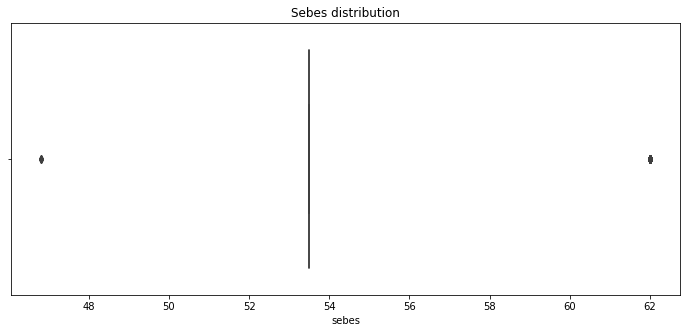

In [554]:
plt.figure(figsize=(12,5))
sns.boxplot(df_et.sebes)
#plt.xticks(rotation=90)
plt.title('Sebes distribution')

Text(0.5, 1.0, 'Amount distribution')

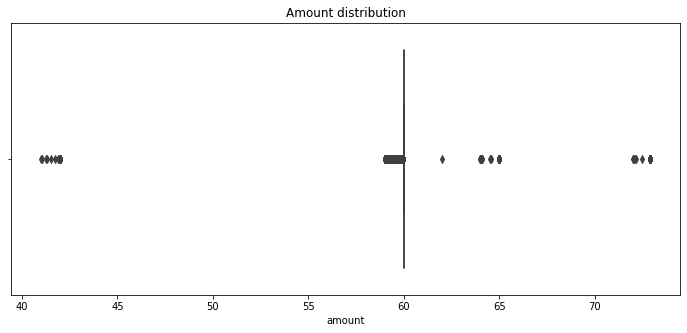

In [553]:
plt.figure(figsize=(12,5))
sns.boxplot(df_et.amount)
#plt.xticks(rotation=90)
plt.title('Amount distribution')

In [551]:
df_et.amount.describe()

count    7881.000000
mean       73.103140
std        34.144389
min        41.000000
25%        59.990000
50%        59.990000
75%        59.990000
max      1199.400000
Name: amount, dtype: float64

## First cleanup

In [552]:
df_et = df_et.query('sebes < 100')
df_et = df_et.query('amount < 100')

## Grouping by date

In [986]:
df = df_et.copy()

In [987]:
df = df.groupby(['date']).sum()

In [988]:
df.head()

,quantity,amount,sebes
date,,,
2021-01-04 00:00:00,7,419.93,374.5
2021-01-05 00:00:00,25,1498.49,1337.5
2021-01-06 00:00:00,20,1199.80,1070.0
2021-01-07 00:00:00,22,1319.64,1177.0
2021-01-08 00:00:00,26,1559.03,1391.0


In [989]:
seb = df.sebes / df_et.groupby(['date']).sebes.count()
df['seb'] = seb
df['price'] = df.amount / df.quantity
df = df.drop(columns = ['sebes']).reset_index()
df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")

In [990]:
df.head()

,date,quantity,amount,seb,price
0,2021-01-04,7,419.93,53.5,59.990000
1,2021-01-05,25,1498.49,53.5,59.939600
2,2021-01-06,20,1199.80,53.5,59.990000
3,2021-01-07,22,1319.64,53.5,59.983636
4,2021-01-08,26,1559.03,53.5,59.962692


## EDA

Text(0.5, 1.0, 'Quantity by date')

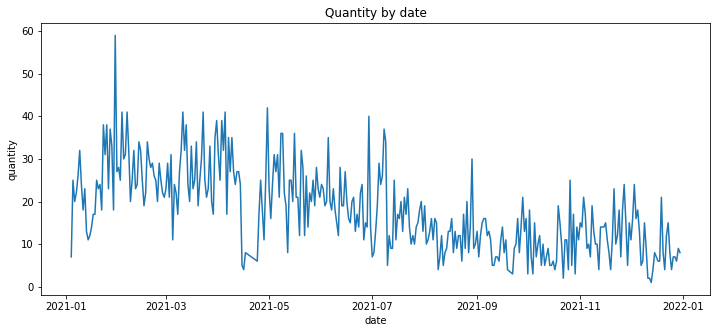

In [562]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='date', y='quantity')
#plt.xticks(rotation=90)
plt.title('Quantity by date')

In [991]:
def date_feat_eng_X1(df):
    data = df.copy()
    data['month']=data['date'].dt.month
    return data

def date_feat_eng_X2(df):
    data = df.copy()
    data['day_of_week']=data['date'].dt.dayofweek
    data['day_of_month']=data['date'].dt.day
    data['dayofyear'] = data['date'].dt.dayofyear  
    data['week']=data['date'].dt.isocalendar().week 
    data['week']=data['week'].astype('int')             
    return data

In [564]:
date_month_dep = date_feat_eng_X1(df)

Text(0.5, 1.0, 'Trend Quantity by month')

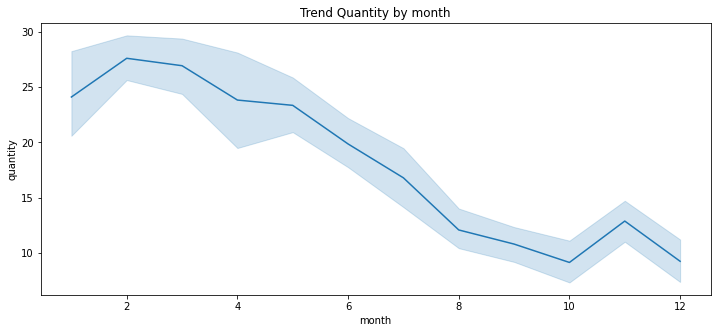

In [567]:
plt.figure(figsize=(12,5))
sns.lineplot(data=date_month_dep, x='month', y='quantity')
#plt.xticks(rotation=90)
plt.title('Trend Quantity by month')

In [966]:
date_week_dep = date_feat_eng_X2(df)

Text(0.5, 1.0, 'Trend Quantity by day_of_week')

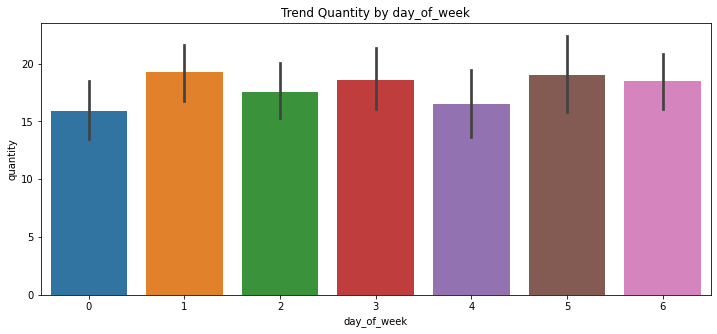

In [569]:
plt.figure(figsize=(12,5))
sns.barplot(data=df, x='day_of_week', y='quantity')
#plt.xticks(rotation=90)
plt.title('Trend Quantity by day_of_week')

Text(0.5, 1.0, 'Trend Quantity by week')

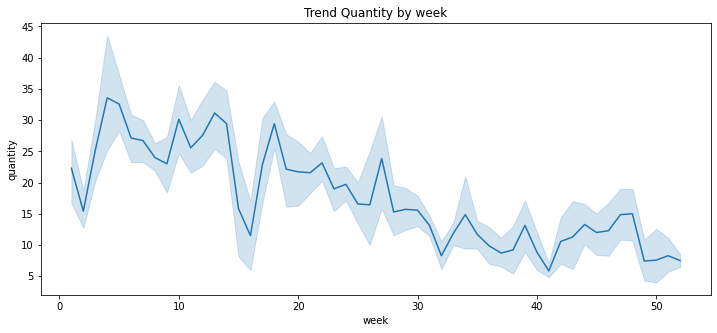

In [570]:
plt.figure(figsize=(12,5))
sns.lineplot(data=date_week_dep, x='week', y='quantity')
#plt.xticks(rotation=90)
plt.title('Trend Quantity by week')

Text(0.5, 1.0, 'Quantity distribution')

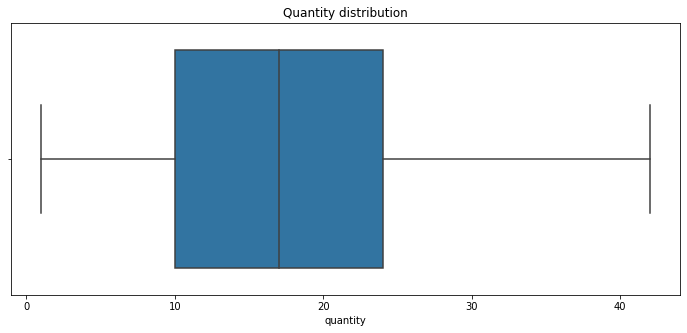

In [994]:
plt.figure(figsize=(12,5))
sns.boxplot(df.quantity)
#plt.xticks(rotation=90)
plt.title('Quantity distribution')

In [993]:
df = df.query('quantity < 50')

Text(0.5, 1.0, 'Prime cost distribution')

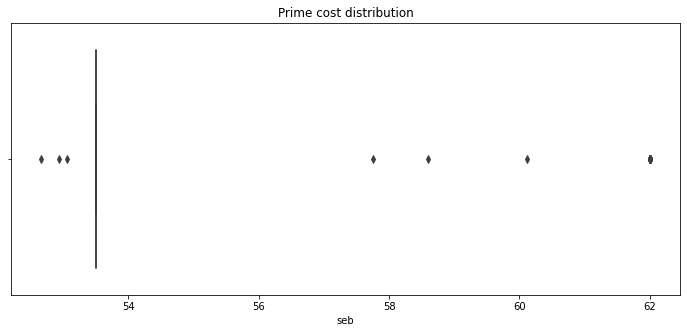

In [574]:
plt.figure(figsize=(12,5))
sns.boxplot(df.seb)
#plt.xticks(rotation=90)
plt.title('Prime cost distribution')

Text(0.5, 1.0, 'Price distribution')

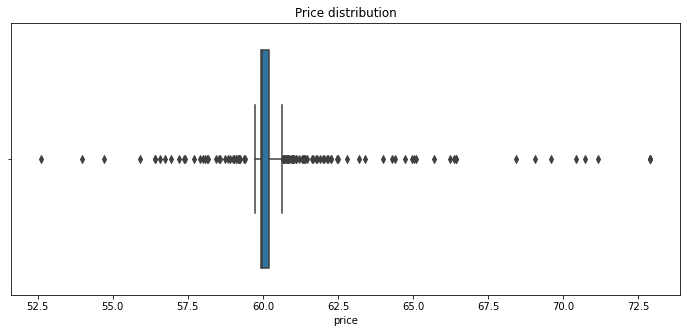

In [575]:
plt.figure(figsize=(12,5))
sns.boxplot(df.price)
#plt.xticks(rotation=90)
plt.title('Price distribution')

## Feature Engineering

In [1384]:
df_test = pd.to_datetime([1, 2, 3, 4, 5, 6], unit='D', origin=pd.Timestamp('2021-12-31'))
df_test = df_test.insert(0, '2021-12-31')
df_test = pd.DataFrame(df_test)
df_test = df_test.rename(columns = {0:'date'})
df_test_lin = date_feat_eng_X1(df_test)
df_test_boost = date_feat_eng_X2(df_test)

In [1385]:
df_test_lin.head()

,date,month
0,2021-12-31,12
1,2022-01-01,1
2,2022-01-02,1
3,2022-01-03,1
4,2022-01-04,1


In [1254]:
def trend_features(df):
    data = df.copy()
    data['margin'] = data.price - data.seb
    
    lag_list = [2,4,6]

    for lag in lag_list:
        ft_name = ('price_shifted%s' % lag)
        data[ft_name] = data['price'].shift(lag)
        data[ft_name].fillna(0, inplace=True)
        
    for lag in lag_list:
        ft_name = ('quan_shifted%s' % lag)
        data[ft_name] = data['quantity'].shift(lag)
        data[ft_name].fillna(0, inplace=True)
        
    data['price_trend'] = data['price']

    for lag in lag_list:
        ft_name = ('price_shifted%s' % lag)
        data['price_trend'] -= data[ft_name]

    data['price_trend'] /= len(lag_list) + 1
    
    data['quan_trend'] = data['quantity']

    for lag in lag_list:
        ft_name = ('quan_shifted%s' % lag)
        data['quan_trend'] -= data[ft_name]

    data['quan_trend'] /= len(lag_list) + 1
    
    return data
    

In [1003]:
def FourierFeatures(df):
    data = df.copy()
    dayofyear = data['date'].dt.dayofyear
    weekofyear = data['date'].dt.isocalendar().week.astype('int')
    data[f'sin1'] = np.sin(dayofyear / 365 * 2 * math.pi)
    data[f'cos1'] = np.cos(dayofyear / 365 * 2 * math.pi)
    data[f'sin2'] = np.sin(weekofyear / 52 * 2 * math.pi)
    data[f'cos2'] = np.cos(weekofyear / 52 * 2 * math.pi)
    return data

In [1386]:
df_test_lin = FourierFeatures(df_test_lin)
df_test_lin = df_test_lin.drop(columns = ['date'])

In [1037]:
df.head(8)

,date,quantity,amount,seb,price
0,2021-01-04,7,419.93,53.5,59.990000
1,2021-01-05,25,1498.49,53.5,59.939600
2,2021-01-06,20,1199.80,53.5,59.990000
3,2021-01-07,22,1319.64,53.5,59.983636
4,2021-01-08,26,1559.03,53.5,59.962692
5,2021-01-09,32,1919.52,53.5,59.985000
6,2021-01-10,24,1439.29,53.5,59.970417
7,2021-01-11,18,1079.31,53.5,59.961667


In [1040]:
df_train_lin = date_feat_eng_X1(df)
df_train_lin = FourierFeatures(df_train_lin)
df_train_lin = df_train_lin.drop(columns = ['date','amount'])

In [1255]:
df_train_boost = trend_features(df)
df_train_boost = date_feat_eng_X2(df_train_boost)
df_train_boost = df_train_boost.drop(columns = ['date', 'amount'])

In [1387]:
data_for_test = df_train_boost[-7:]
data_for_test = data_for_test.drop(columns = ['quantity', 'day_of_week','day_of_month', 'dayofyear' ,'week'])

In [1388]:
data_for_test = data_for_test.reset_index()

In [1389]:
data_for_test = data_for_test.drop(columns = ['index'])

In [1390]:
#df_test_boost = date_feat_eng_X2(df_test)
df_test_boost = df_test_boost.drop(columns = ['date'])
df_test_boost = pd.concat([df_test_boost, data_for_test], axis=1)

In [1391]:
df_test_boost.head(8)

,day_of_week,day_of_month,dayofyear,week,seb,price,margin,price_shifted2,price_shifted4,price_shifted6,quan_shifted2,quan_shifted4,quan_shifted6,price_trend,quan_trend
0,4,31,365,52,62.0,64.738750,2.738750,66.440000,69.077500,68.426667,12.0,8.0,6.0,-34.801354,-4.50
1,5,1,1,52,62.0,65.715000,3.715000,64.956667,69.600000,65.096190,15.0,4.0,21.0,-33.484464,-9.00
2,6,2,2,52,62.0,64.390000,2.390000,64.738750,66.440000,69.077500,8.0,12.0,8.0,-33.966562,-5.25
3,0,3,3,1,62.0,65.044286,3.044286,65.715000,64.956667,69.600000,4.0,15.0,4.0,-33.806845,-4.00
4,1,4,4,1,62.0,70.445000,8.445000,64.390000,64.738750,66.440000,7.0,8.0,12.0,-31.280937,-5.25
5,2,5,5,1,62.0,64.290000,2.290000,65.044286,65.715000,64.956667,7.0,4.0,15.0,-32.856488,-4.25
6,3,6,6,1,62.0,71.166250,9.166250,70.445000,64.390000,64.738750,6.0,7.0,8.0,-32.101875,-3.25


In [1392]:
data_for_test_lin = df[-7:]

In [1393]:
df_test_lin[['seb', 'price']] = data_for_test_lin[['seb', 'price']].values

In [1394]:
print('Data Shapes:\n', df_train_lin.shape, '\n', df_test_lin.shape, '\n', df_train_boost.shape, '\n', df_test_boost.shape, '\n')

Data Shapes:
 (352, 8) 
 (7, 7) 
 (352, 16) 
 (7, 15) 



In [1336]:
df_test_boost.head()

,day_of_week,day_of_month,dayofyear,week,index,seb,price,margin,price_shifted2,price_shifted4,price_shifted6,quan_shifted2,quan_shifted4,quan_shifted6,price_trend,quan_trend
0,4,31,365,52,346,62.0,64.738750,2.738750,66.440000,69.077500,68.426667,12.0,8.0,6.0,-34.801354,-4.50
1,5,1,1,52,347,62.0,65.715000,3.715000,64.956667,69.600000,65.096190,15.0,4.0,21.0,-33.484464,-9.00
2,6,2,2,52,348,62.0,64.390000,2.390000,64.738750,66.440000,69.077500,8.0,12.0,8.0,-33.966562,-5.25
3,0,3,3,1,349,62.0,65.044286,3.044286,65.715000,64.956667,69.600000,4.0,15.0,4.0,-33.806845,-4.00
4,1,4,4,1,350,62.0,70.445000,8.445000,64.390000,64.738750,66.440000,7.0,8.0,12.0,-31.280937,-5.25


In [1432]:
df_valid_lin = df_train_lin[-14:]
df_valid_boost  = df_train_boost[-14:]

In [1396]:
df_valid_lin.shape

(14, 8)

In [1397]:
df_valid_boost.shape

(14, 16)

In [1433]:
df_train_lin_final = df_train_lin.iloc[8:352]
df_train_boost_final = df_train_boost.iloc[8:352]
df_train_lin_final = df_train_lin_final.drop(columns = 'quantity')
Y_train = df_train_boost_final.pop('quantity')
df_valid_lin = df_valid_lin.drop(columns = 'quantity')
Y_valid = df_valid_boost.pop('quantity')

In [1399]:
df_valid_lin.shape

(14, 7)

In [1400]:
df_valid_boost.shape

(14, 15)

In [1435]:
test_lin = pd.concat([df_valid_lin, df_test_lin])
test_boost = pd.concat([df_valid_boost, df_test_boost])

## HyperModel

In [1424]:
class HybridModel:
    def __init__(self, model_1, model_2, grid=None):
        self.model_1 = model_1
        self.model_2 = model_2
        self.grid = grid
        
    def fit(self, X_train_1, X_train_2, y):
        self.model_1.fit(X_train_1, y)
        
        y_trend = self.model_1.predict(X_train_1)

        if self.grid:
            tscv = TimeSeriesSplit(n_splits=7)
            grid_model = GridSearchCV(estimator=self.model_2, cv=tscv, param_grid=self.grid)
        
            grid_model.fit(X_train_2, y-y_trend)
           
            y_resid = grid_model.predict(X_train_2)
            
            
            self.grid_model=grid_model
        else:
            self.model_2.fit(X_train_2, y-y_trend)
            
            y_resid = self.model_2.predict(X_train_2)
        try:
            plt.rcParams["figure.figsize"] = (15, 6)
            l_pi(grid_model.best_estimator_)
            plt.show()
        except:
            pass
        try:
            plt.rcParams["figure.figsize"] = (15, 6)
            plot_importance(grid_model.best_estimator_)
            plt.show()
        except:
            pass
        
    def predict(self, X_test_1, X_test_2):
        y_trend = self.model_1.predict(X_test_1)
        
        if self.grid:
            y_resid = self.grid_model.predict(X_test_2)
        else:
            y_resid = self.model_2.predict(X_test_2)
        
        y_pred = y_trend + y_resid
        
        return y_pred

## Prediction

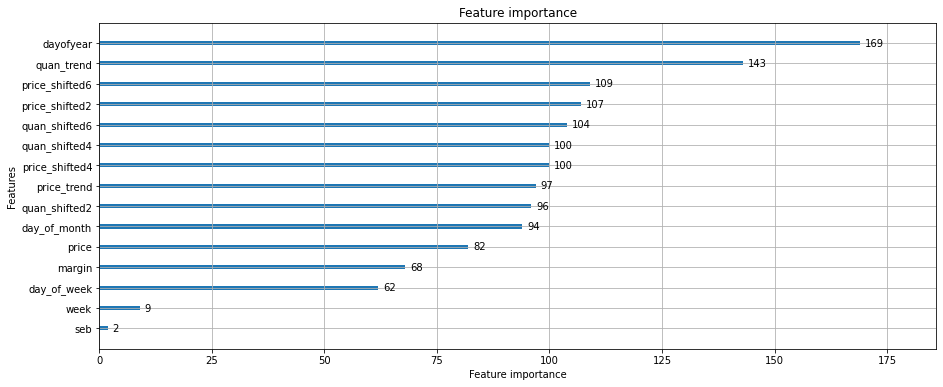

Model_2:LGBMRegressor(random_state=32) -- time:0.12 mins
Best parameters: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 110} 



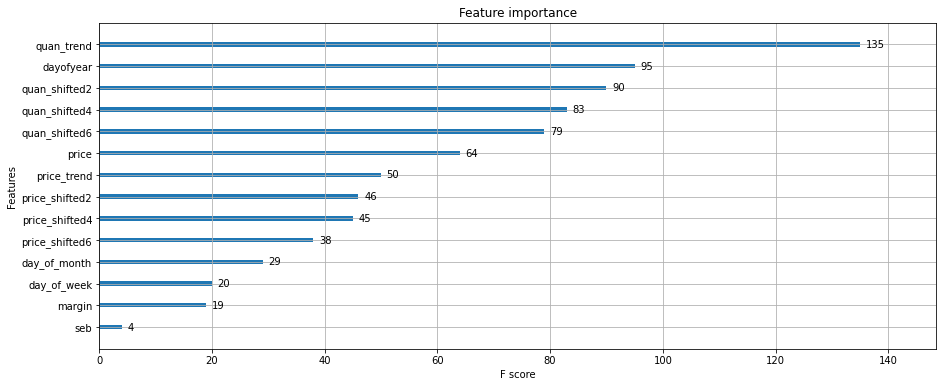

Model_2:XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=32, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) -- time:0.6 mins
Best parameters: {'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 120} 



In [1436]:
model_1 = LinearRegression()
models_2 = [LGBMRegressor(random_state=32), XGBRegressor(random_state=32)]


param_grid = {'n_estimators': [105, 110, 120],
        'max_depth': [3, 7, 10],
        'learning_rate': [0.15, 0.2, 0.25, 0.3]}

y_pred = np.zeros(len(test_lin))

for model_2 in models_2:
    start = time.time()
    
    model = HybridModel(model_1, model_2, grid = param_grid)

    model.fit(df_train_lin_final, df_train_boost_final, np.log(Y_train))

    y_pred += np.exp(model.predict(test_lin, test_boost))
    stop = time.time()
    
    print(f'Model_2:{model_2} -- time:{round((stop-start)/60,2)} mins')
    
    if model.grid:
        print('Best parameters:',model.grid_model.best_params_,'\n')

y_pred = y_pred/len(models_2)

In [1437]:
def geometric_round(arr):
    result_array = arr
    result_array = np.where(result_array < np.sqrt(np.floor(arr)*np.ceil(arr)), np.floor(arr), result_array)
    result_array = np.where(result_array >= np.sqrt(np.floor(arr)*np.ceil(arr)), np.ceil(arr), result_array)
    return result_array

y_pred = geometric_round(y_pred)

## Validation 

In [1280]:
print('Validation: 2 weeks and reduced step in shift(2,4,6) with more estimators\nMSE\t', mean_squared_error(Y_valid, y_pred))
print('MAE\t',mean_absolute_error(Y_valid, y_pred))

Validation: 2 weeks and reduced step in shift(2,4,6) with more estimators
MSE	 8.857142857142858
MAE	 2.4285714285714284


## Test

In [1466]:
submission = pd.to_datetime([1, 2, 3, 4, 5, 6], unit='D', origin=pd.Timestamp('2021-12-31'))
submission = submission.insert(0, '2021-12-31')
submission = pd.DataFrame(submission, y_pred_test)
submission = submission.rename(columns = {0:'dates'})

In [1468]:
submission = submission.reset_index().rename(columns = {'index':'quantities'})

In [1469]:
submission

,quantities,dates
0,8.0,2021-12-31
1,5.0,2022-01-01
2,10.0,2022-01-02
3,9.0,2022-01-03
4,8.0,2022-01-04
5,11.0,2022-01-05
6,9.0,2022-01-06


In [1471]:
submission.to_csv('imprice_subm.csv', index = False)